In [76]:
import os
os.chdir('..')
import numpy as np
from notebooks import config
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff,  writeTiff
from utils.imgShow import imgShow
from utils.crop_to_extent import crop_to_extent
from utils.raster_vec import vec2mask

In [17]:
path_srtm_c = config.root_proj + '/data/dem/srtm-c/SRTMGL1_wkunlun_wgs84V.tif'
path_tandem = config.root_proj + '/data/dem/tandem-x/tandem_wkunlun_resize.tif'
path_img = config.root_proj + '/data/rsimg/l8_kunlun_20200914.tif'


In [60]:
img_srtm_c, img_srtm_c_info = readTiff(path_srtm_c)
img_tandem, img_tandem_info = readTiff(path_tandem)
rs_img, rs_img_info = readTiff(path_img)
print('rstm shape:',   img_srtm_c.shape, 'extent:', img_srtm_c_info['geoextent'])
print('tandem shape:', img_tandem.shape, 'extent',  img_tandem_info['geoextent'])


rstm shape: (3401, 6562) extent: (80.117638889, 81.94041666686216, 34.90763888873405, 35.852361111)
tandem shape: (3401, 6562) extent (80.117638889, 81.94041666686216, 34.90763888873405, 35.852361111)


### Check dem image

Text(0.5, 1.0, 'srtm-c image')

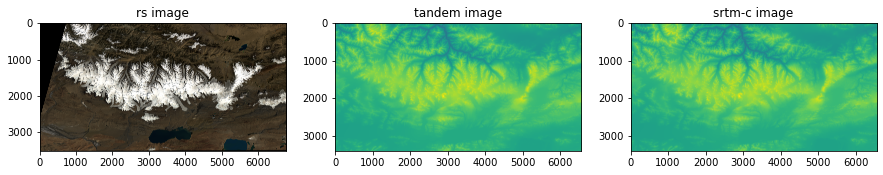

In [64]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
imgShow(rs_img)
plt.title('rs image')
plt.subplot(1,3,2)
plt.imshow(img_tandem, vmin=2000, vmax=7000)
plt.title('tandem image')
plt.subplot(1,3,3)
plt.imshow(img_srtm_c, vmin=2000, vmax=7000)
plt.title('srtm-c image')


### Mask dem with rgi glacier and jrc water data

In [65]:
path_water_jrc = config.root_proj + '/data/water_jrc/wkl_water_jrc.tif'      # jrc water map
path_rgi_1305 = config.root_proj + '/data/rgi/rgi60_1305/rgi60_1305.shp'     # rgi glacier data


### Water mask

In [70]:
water_jrc, water_jrc_info = readTiff(path_water_jrc)
extent_base = img_srtm_c_info['geoextent']
size_base = [img_srtm_c_info['row'], img_srtm_c_info['col']]
water_jrc_crop = crop_to_extent(path_img=path_water_jrc, \
                                extent_target=extent_base, size_target=size_base)
water_jrc_crop = np.ma.masked_where(water_jrc_crop>50, water_jrc_crop)


### Glacier mask

In [71]:
rgi_img = vec2mask(path_raster=path_srtm_c, path_vec=path_rgi_1305, path_save=None)
rgi_img = np.ma.masked_equal(rgi_img, 1)

In [94]:
mask = np.logical_or(water_jrc_crop.mask, rgi_img.mask)


### Apply the mask

In [73]:
img_srtm_c_masked = np.ma.array(img_srtm_c, mask=mask, fill_value=0).astype(np.float32).filled(np.nan)
img_tandem_masked = np.ma.array(img_tandem, mask=mask, fill_value=0).astype(np.float32).filled(np.nan)


Text(0.5, 1.0, 'masked srtm-c image')

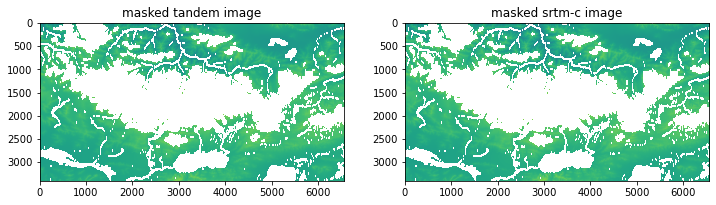

In [74]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(img_tandem_masked, vmin=2000, vmax=7000)
plt.title('masked tandem image')
plt.subplot(1,2,2)
plt.imshow(img_srtm_c_masked, vmin=2000, vmax=7000)
plt.title('masked srtm-c image')



### Co-registration (take srtm-c as reference) by using method proposed by [Nuth and Kääb (2011)](https://www.the-cryosphere.net/5/271/2011/tc-5-271-2011.html)